In [1]:
import sympy
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from expanders import *

### Margulis degree 8 construction

In [2]:
m = 10

builder = Margulis(m, remove_parallel_edges=False, remove_self_edges=False)
builder.build()
G = builder.G

n = G.number_of_nodes()

### Graph

/home/sauxpa/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):
/home/sauxpa/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:676: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if cb.iterable(node_size):  # many node sizes


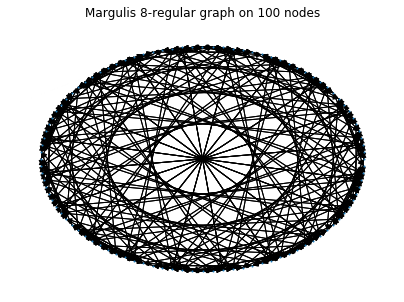

In [3]:
# save layout
pos = nx.shell_layout(G)

fig, ax = plt.subplots(figsize=(7, 5), nrows=1, ncols=1)

nx.draw_networkx(G, pos=pos, ax=ax, with_labels=False, node_size=1)
ax.set_title('Margulis 8-regular graph on {} nodes'.format(G.number_of_nodes()))
ax.axis('off')

plt.show()

### Eigenvalues vs Alon-Boppana bound

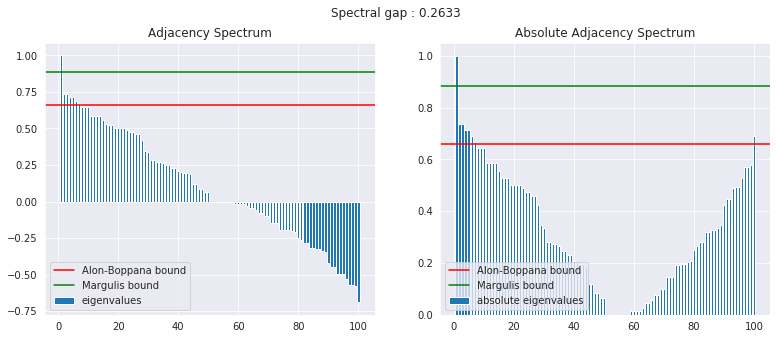

In [4]:
with sns.axes_style("darkgrid"):
    fig, axes = plt.subplots(figsize=(13, 5), nrows=1, ncols=2)

    fig.suptitle('Spectral gap : {:.4f}'.format(builder.normalized_spectral_gap))
    
    ax = axes[0]    
    ax.bar(range(1, n+1), builder.normalized_spectrum, label='eigenvalues')
    ax.axhline(y=alon_boppana(8, normalized=True), color='r', label='Alon-Boppana bound')
    ax.axhline(y=builder.margulis_bound(normalized=True), color='g', label='Margulis bound')
    ax.set_title('Adjacency Spectrum')
    ax.legend(loc='lower left')

    ax = axes[1]
    ax.bar(range(1, n+1), np.abs(builder.normalized_spectrum), label='absolute eigenvalues')
    ax.axhline(y=alon_boppana(8, normalized=True), color='r', label='Alon-Boppana bound')
    ax.axhline(y=builder.margulis_bound(normalized=True), color='g', label='Margulis bound')
    ax.set_title('Absolute Adjacency Spectrum')
    ax.legend(loc='lower left')

    plt.show()

In [5]:
builder.is_ramanujan

False

## Spectral and mixing properties : comparison with balanced trees.

/home/sauxpa/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):


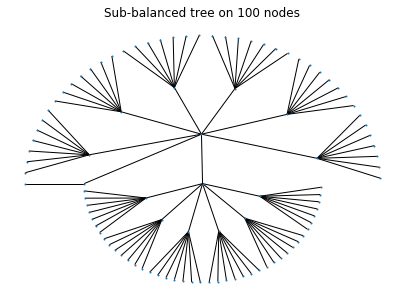

In [6]:
d = 8
h = int(np.floor(np.log(n*(d-2) + 1)/np.log(d-1))) - 1
# Consider one extra height level in the tree...
G_tree = nx.balanced_tree(d-1, h+1)
# ... and remove the additional nodes to have the same number of nodes as G
G_tree = nx.MultiGraph(G_tree.subgraph(list(G_tree.nodes)[:n]))

# To make it more regular, add self-edges to the leaves.
leaves = [node for node in G_tree.nodes if G_tree.degree(node) == 1]
G_tree.add_edges_from([(leaf, leaf) for leaf in leaves for _ in range(d-1)])

# save layout
pos = nx.drawing.nx_agraph.graphviz_layout(G_tree, prog='twopi', args='')

fig, ax = plt.subplots(figsize=(7, 5), nrows=1, ncols=1)

nx.draw_networkx(G_tree, pos=pos, ax=ax, with_labels=False, node_size=1)
ax.set_title('Sub-balanced tree on {} nodes'.format(n))
ax.axis('off')

plt.show()

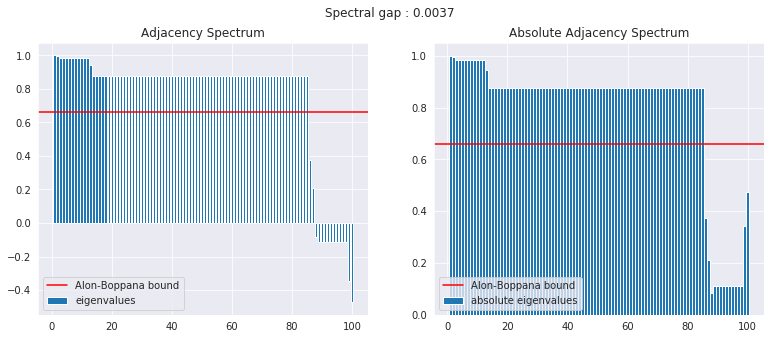

In [7]:
P_tree = transition_matrix(G_tree)

spectrum_tree = normalized_spectrum(P_tree)
spectral_gap_tree = spectral_gap(spectrum_tree)

with sns.axes_style("darkgrid"):
    fig, axes = plt.subplots(figsize=(13, 5), nrows=1, ncols=2)

    fig.suptitle('Spectral gap : {:.4f}'.format(spectral_gap_tree))
    
    ax = axes[0]    
    ax.bar(range(1, n+1), spectrum_tree, label='eigenvalues')
    ax.axhline(y=alon_boppana(8, normalized=True), color='r', label='Alon-Boppana bound')
    ax.set_title('Adjacency Spectrum')
    ax.legend(loc='lower left')

    ax = axes[1]
    ax.bar(range(1, n+1), np.abs(spectrum_tree), label='absolute eigenvalues')
    ax.axhline(y=alon_boppana(8, normalized=True), color='r', label='Alon-Boppana bound')
    ax.set_title('Absolute Adjacency Spectrum')
    ax.legend(loc='lower left')

    plt.show()

### Mixing times

Note that graphs extracted from balanced trees induce periodic Markov chain walks (of period 2 : every round trip from one node to itself takes an even number of steps because there is a single path connecting any two points in the tree, therefore the only way to make round trips is to go somewhere in the tree and trace the steps back). 

This would prevent the mixing, in the sense that $P^t$ would not converge to the stationary distribution when $t\rightarrow \infty$. That is why we have added an extra self-edge to the leaves, making the walks aperiodic.

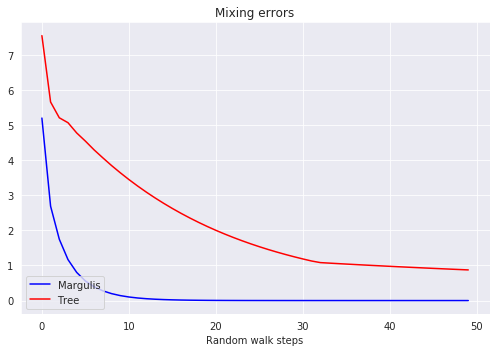

In [8]:
walk_length = 50
n_samples = int(1e3) # Evaluate mxing against random initial distributions
# n_samples = -1 # Evaluate mxing against Dirac masses at each node
mixing_err = builder.mixing_errors(walk_length, n_samples)
mixing_err_tree = mixing_errors(P_tree, invariant_distribution(P_tree), walk_length, n_samples)

with sns.axes_style("darkgrid"):
    fig, ax = plt.subplots(figsize=(7, 5), nrows=1, ncols=1)
    ax.plot(mixing_err, label='Margulis', color='b')
    ax.plot(mixing_err_tree, label='Tree', color='r')
    ax.set_xlabel('Random walk steps')
    ax.set_title('Mixing errors')
    ax.legend(loc='lower left')
    plt.tight_layout()
    plt.show()

### Expected entropic evolution

Compute $t\mapsto \mathbb{E}\big[H(vP^t) - H(v)\big]$ i.e the increase in entropy after $t$ steps of mixing average across random initial distribution $v$ sampled uniformly.

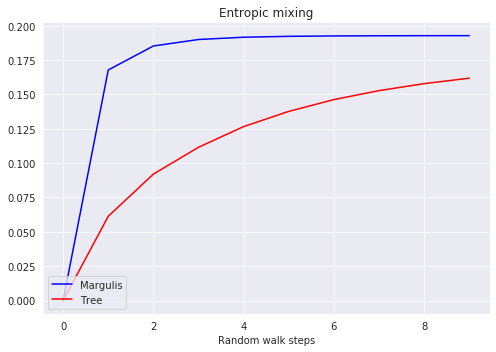

In [9]:
walk_length = 10
n_samples = int(1e3) # Evaluate mxing against random initial distributions
# n_samples = -1 # Evaluate mxing against Dirac masses at each node
entropy_diff = builder.entropy_mixing(walk_length, n_samples)

entropy_diff_tree = entropy_mixing(P_tree, walk_length, n_samples)

with sns.axes_style("darkgrid"):
    fig, ax = plt.subplots(figsize=(7, 5), nrows=1, ncols=1)
    ax.plot(entropy_diff, label='Margulis', color='b')
    ax.plot(entropy_diff_tree, label='Tree', color='r')
    ax.set_xlabel('Random walk steps')
    ax.set_title('Entropic mixing')
    ax.legend(loc='lower left')
    plt.tight_layout()
    plt.show()

### Mutual Information Mixing

We define the Mutual Information Mixing on graph $\mathcal{G}$ as :
$$
mi_t = MI(X_0, X_t) = KL(p_{(X_0, X_t)} || p_{X_0} \otimes p_{X_t} )
$$
where $X_0 \sim \text{Uniform}(\mathcal{G})$ and $X_t = \text{random state of the walk on } \mathcal{G} \text{ after } t \text{ steps}$.

Intuitively, if a graph has good mixing properties, the distribution of $X_t$ shares very little information with the initial seeding $X_0$.

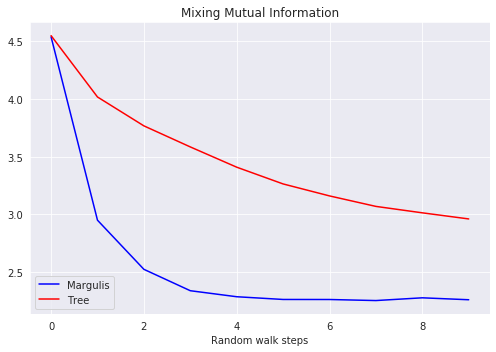

In [10]:
walk_length = 10
n_samples = int(1e3) # Evaluate mxing against random initial distributions

mixing_mi = builder.mi_mixing(walk_length, n_samples)
mixing_mi_tree = mi_mixing(P_tree, walk_length, n_samples)

with sns.axes_style("darkgrid"):
    fig, ax = plt.subplots(figsize=(7, 5), nrows=1, ncols=1)
    ax.plot(mixing_mi, label='Margulis', color='b')
    ax.plot(mixing_mi_tree, label='Tree', color='r')
    ax.set_xlabel('Random walk steps')
    ax.set_title('Mixing Mutual Information')
    ax.legend(loc='lower left')
    plt.tight_layout()
    plt.show()

## Spectral and mixing properties : comparison with random Erdös-Renyi graph of same expected degree.

An Erdös-Renyi graph $G(n,p)$ exhibits a connectivity transition phase with sharp threshold for $p$ equal to $\frac{\log n}{n}$, i.e if $p>\frac{(1+\varepsilon) \log n}{n}$ it will almost surely be connected, for $n$ large enough.

To compare with the Margulis construction, we need to have an average degree of $8$, i.e $p=\frac{8}{n-1}$. Put together, we need $\log n \lesssim 8$, i.e $n \lesssim 3000$.

In [11]:
def generate_erdos_renyi(verbose=False):
    """Helper routine to generate Erdös-Renyi graphs on n vertices
    with average degree 8.
    """
    prob = 8 / (n-1)
    max_try = 100
    for k in range(max_try):
        G_Erdos_Renyi = nx.fast_gnp_random_graph(n, prob)
        if nx.is_connected(G_Erdos_Renyi):
            if verbose:
                print('G(n,p) is connected after {} trial(s)'.format(k+1))
            break
    else:
        if verbose:
            print('G(n,p) is not connected after {} trials'.format(max_try))
        return nx.Graph()
    
    return G_Erdos_Renyi

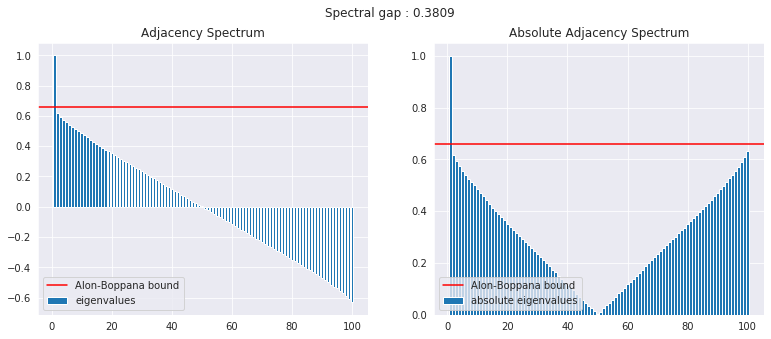

In [12]:
# Average mixing errors over a few Erdos-Renyi graphs
n_Erdos_Renyi = 20
Gs_Erdos_Renyi = [generate_erdos_renyi() for _ in range(n_Erdos_Renyi)]
Ps_Erdos_Renyi = [transition_matrix(G_ER) for G_ER in Gs_Erdos_Renyi]
spectrums_Erdos_Renyi = [normalized_spectrum(P_ER) for P_ER in Ps_Erdos_Renyi]
spectral_gaps_Erdos_Renyi = [spectral_gap(spectrum_ER) for spectrum_ER in spectrums_Erdos_Renyi]

spectrum_Erdos_Renyi = np.mean(np.array(spectrums_Erdos_Renyi), axis=0)
spectral_gap_Erdos_Renyi = np.mean(np.array(spectral_gaps_Erdos_Renyi), axis=0)

with sns.axes_style("darkgrid"):
    fig, axes = plt.subplots(figsize=(13, 5), nrows=1, ncols=2)

    fig.suptitle('Spectral gap : {:.4f}'.format(spectral_gap_Erdos_Renyi))
    
    ax = axes[0]    
    ax.bar(range(1, n+1), spectrum_Erdos_Renyi, label='eigenvalues')
    ax.axhline(y=alon_boppana(8, normalized=True), color='r', label='Alon-Boppana bound')
    ax.set_title('Adjacency Spectrum')
    ax.legend(loc='lower left')

    ax = axes[1]
    ax.bar(range(1, n+1), np.abs(spectrum_Erdos_Renyi), label='absolute eigenvalues')
    ax.axhline(y=alon_boppana(8, normalized=True), color='r', label='Alon-Boppana bound')
    ax.set_title('Absolute Adjacency Spectrum')
    ax.legend(loc='lower left')

    plt.show()

### Mixing times

100%|██████████| 20/20 [00:01<00:00, 14.46it/s]


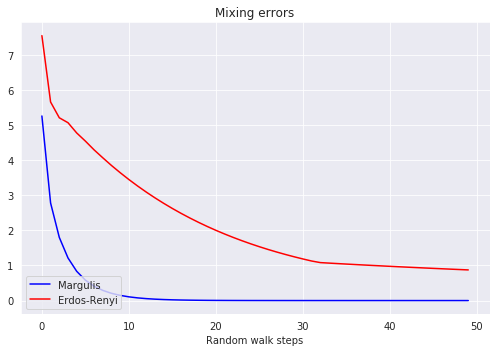

In [13]:
walk_length = 50
n_samples = int(1e3) # Evaluate mxing against random initial distributions
# n_samples = -1 # Evaluate mxing against Dirac masses at each node

mus_Erdos_Renyi = [invariant_distribution(P_ER) for P_ER in Ps_Erdos_Renyi]

mixing_err = builder.mixing_errors(walk_length, n_samples)
mixing_err_Erdos_Renyi = np.zeros(walk_length)

with tqdm(total=n_Erdos_Renyi) as pbar:
    for i, P_ER in enumerate(Ps_Erdos_Renyi):
        mixing_err_Erdos_Renyi += mixing_errors(P_ER, 
                                                invariant_distribution(P_ER), 
                                                walk_length, 
                                                n_samples) / n_Erdos_Renyi
        pbar.update(1)

with sns.axes_style("darkgrid"):
    fig, ax = plt.subplots(figsize=(7, 5), nrows=1, ncols=1)
    ax.plot(mixing_err, label='Margulis', color='b')
    ax.plot(mixing_err_tree, label='Erdos-Renyi', color='r')
    ax.set_xlabel('Random walk steps')
    ax.set_title('Mixing errors')
    ax.legend(loc='lower left')
    plt.tight_layout()
    plt.show()

### Expected entropic mixing

100%|██████████| 20/20 [00:25<00:00,  1.27s/it]


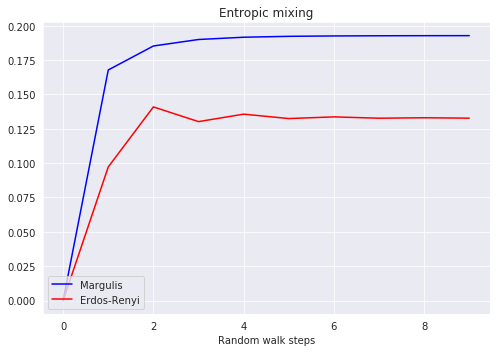

In [14]:
walk_length = 10
n_samples = int(1e3) # Evaluate mxing against random initial distributions
# n_samples = -1 # Evaluate mxing against Dirac masses at each nodeentropy_diff = builder.entropy_mixing(walk_length, n_samples)

entropy_diff_Erdos_Renyi = np.zeros(walk_length)
with tqdm(total=n_Erdos_Renyi) as pbar:
    for i, P_ER in enumerate(Ps_Erdos_Renyi):
        entropy_diff_Erdos_Renyi += entropy_mixing(P_ER, walk_length, n_samples) / n_Erdos_Renyi
        pbar.update(1)

with sns.axes_style("darkgrid"):
    fig, ax = plt.subplots(figsize=(7, 5), nrows=1, ncols=1)
    ax.plot(entropy_diff, label='Margulis', color='b')
    ax.plot(entropy_diff_Erdos_Renyi, label='Erdos-Renyi', color='r')
    ax.set_xlabel('Random walk steps')
    ax.set_title('Entropic mixing')
    ax.legend(loc='lower left')
    plt.tight_layout()
    plt.show()

### Mutual Information Mixing

100%|██████████| 20/20 [00:11<00:00,  1.67it/s]


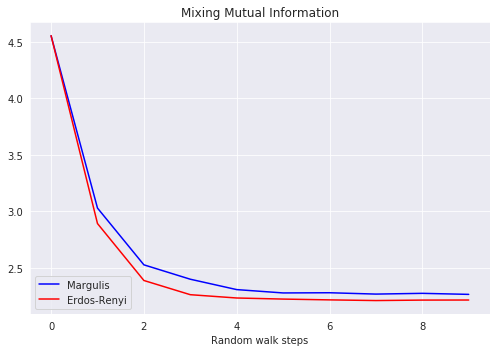

In [15]:
walk_length = 10
n_samples = int(1e3)
mixing_mi = builder.mi_mixing(walk_length, n_samples)

mixing_mi_Erdos_Renyi = np.zeros(walk_length)
with tqdm(total=n_Erdos_Renyi) as pbar:
    for i, P_ER in enumerate(Ps_Erdos_Renyi):
        mixing_mi_Erdos_Renyi += mi_mixing(P_ER, walk_length, n_samples) / n_Erdos_Renyi
        pbar.update(1)

with sns.axes_style("darkgrid"):
    fig, ax = plt.subplots(figsize=(7, 5), nrows=1, ncols=1)
    ax.plot(mixing_mi, label='Margulis', color='b')
    ax.plot(mixing_mi_Erdos_Renyi, label='Erdos-Renyi', color='r')
    ax.set_xlabel('Random walk steps')
    ax.set_title('Mixing Mutual Information')
    ax.legend(loc='lower left')
    plt.tight_layout()
    plt.show()

### Conclusion
The Margulis construction has empirically better expansion properties than graphs extracted from balanced trees or typical random graphs such as Erdos-Renyi.